# Bayesian analysis of the empirical saturation point (refactored version)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Performing Bayesian linear regression on EFT predictions (Coester Band)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_1, beta_0]


/opt/homebrew/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 20 seconds.


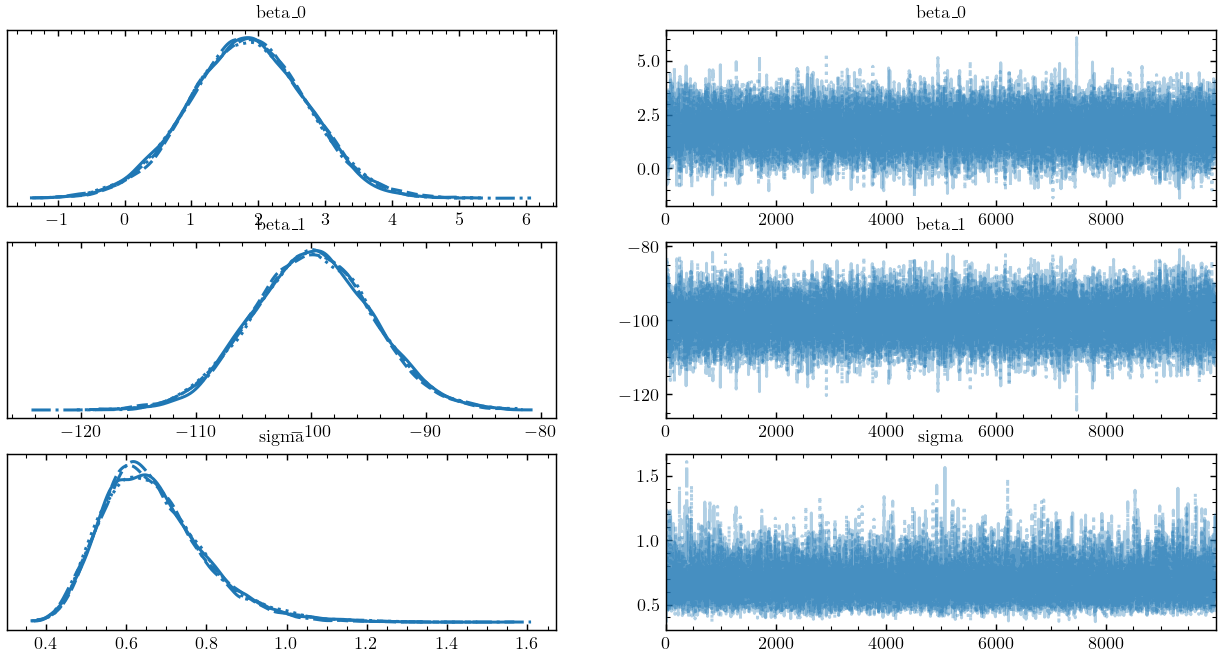

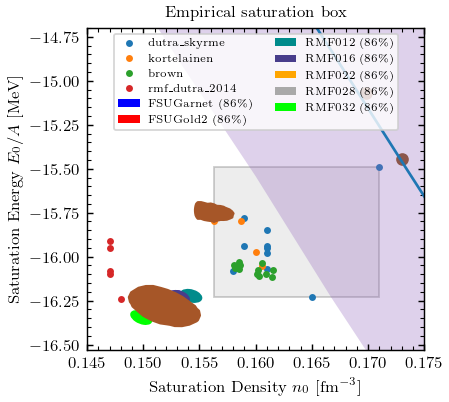

In [14]:
from modules.SaturationAnalysis import SaturationAnalysis
analysis = SaturationAnalysis()
analysis.plot_contraints(eft=True, eft_conf_level=0.95)

## Priors

Let's take a look at the priors used in this work. They can be specified in the file `modules/priors.py`.

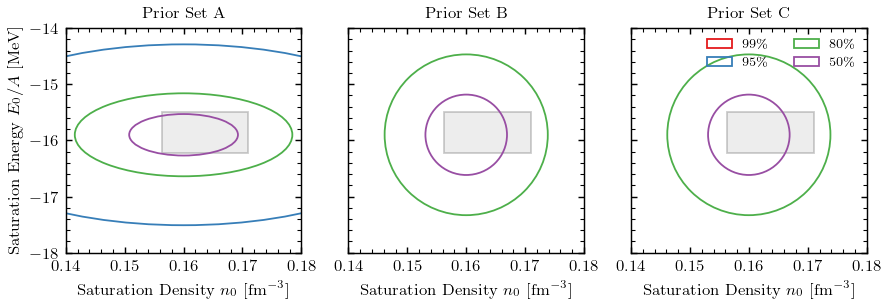

In [15]:
from modules.SaturationAnalysis import visualize_priors
from modules.priors import *
visualize_priors(used_prior_sets)

We use an uninformed prior (left) and an informed prior (right) and something in between (center panel) to investigate the prior sensitivity of our Bayesian inference.

## Saturation box in Drischler et al. (2016)

### Apply our statistical model directly

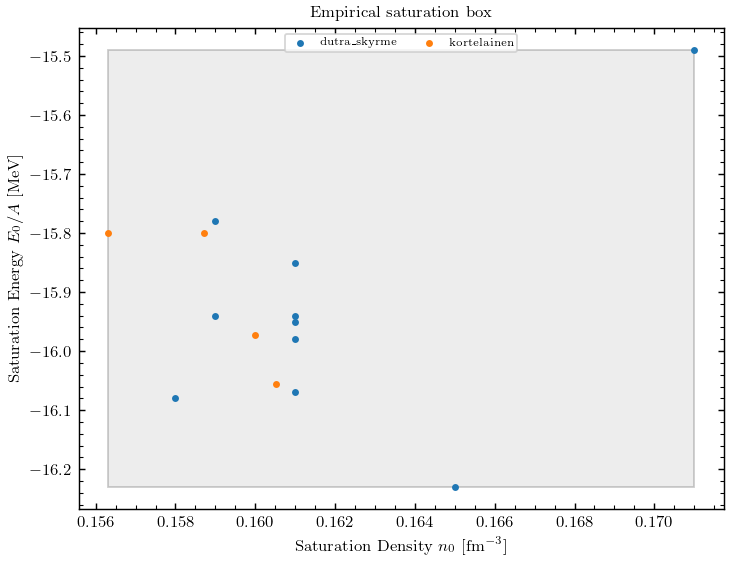

In [11]:
from modules.SaturationAnalysis import drischler_satbox
drischler_satbox.plot(plot_box_estimate=True)

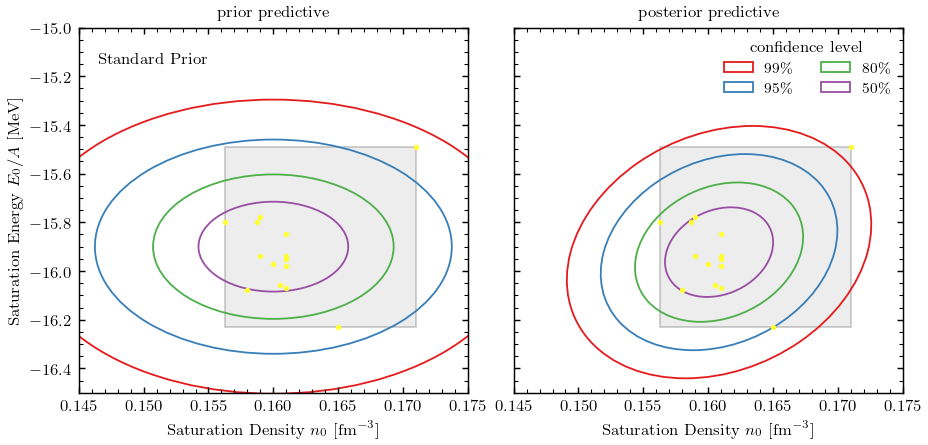

In [12]:
from modules.StatisticalModel import StatisticalModel
model = StatisticalModel(data=drischler_satbox.data_frame)
fig, axs = model.plot_predictives(validate=False)
fig.savefig("test")

(<Figure size 911.024x440.157 with 3 Axes>,
 array([[<AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >]], dtype=object))

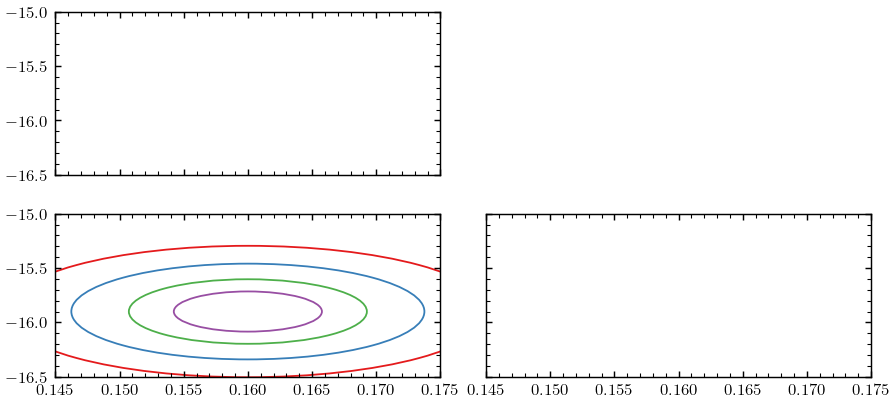

In [13]:
model.plot_predictives_corner()

In [146]:
model.prior_params

{'mu': array([  0.16, -15.9 ]),
 'Psi': array([[1.000e-04, 0.000e+00],
        [0.000e+00, 1.024e-01]]),
 'kappa': 1,
 'nu': 10,
 'label': 'Standard Prior'}

In [32]:
model.posterior_params

{'kappa': 15,
 'nu': 24,
 'mu': array([  0.16083667, -15.92253333]),
 'Psi': array([[2.62060933e-04, 2.55211333e-03],
        [2.55211333e-03, 5.11603733e-01]])}

### Alternative: use a single Monte Carlo step

In [14]:
from modules.DataSets import DataSetSampleConfig, Scenario
scenario1 = Scenario(label="Drischler Satbox",
                     configs=[DataSetSampleConfig(data_set=drischler_satbox)])

In [ ]:
analysis.multiverse(scenario1, num_realizations=1, prior_params=standard_prior_params)

## Hierarchical model

In [60]:
from modules.DataSets import DataSetSampleConfig, Scenario
from modules.SaturationAnalysis import DEFAULT_DFT_CONSTRAINTS as dft_constraints
scenario1 = Scenario(label="FSU-only",
                     configs=[DataSetSampleConfig(data_set=dft_constraints["FSU"])])
scenario2 = Scenario(label="FSU+Schunck-only",
                     configs=[DataSetSampleConfig(data_set=dft_constraints["FSU"]),
                              DataSetSampleConfig(data_set=dft_constraints["Schunck"])])
scenario3 = Scenario(label="all",
                     configs=[DataSetSampleConfig(data_set=dft_constraints[lbl]) for lbl in dft_constraints.keys()])
scenario4 = Scenario(label="Giuliani+Schunck-only",
                     configs=[DataSetSampleConfig(data_set=dft_constraints["Giuliani"]),
                              DataSetSampleConfig(data_set=dft_constraints["Schunck"])])

In [74]:
scenarioX = Scenario(label="test-scenario",
                     configs=[DataSetSampleConfig(data_set=dft_constraints["Dutra_skyrme"])])

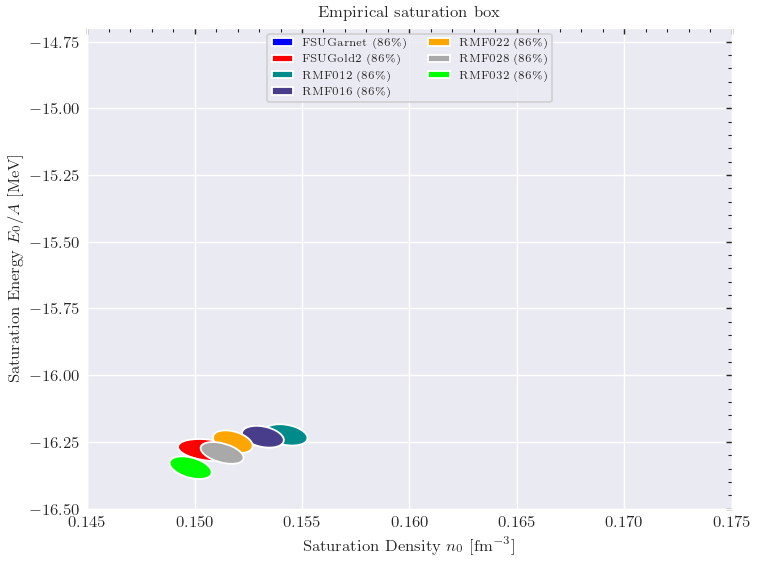

In [61]:
scenario1.configs[0].data_set.plot()

In [ ]:
analysis.multiverse(scenarioX, prior_params=standard_prior_params)

In [ ]:
analysis.multiverse(scenario2)

In [ ]:
analysis.multiverse(scenario3)

In [ ]:
analysis.multiverse(scenario4)

In [ ]:
analysis.plot_individual_models()